# Image Class Prediction  on  CIFAR10 Dataset

In [1]:
import torch
import torch.nn as nn

In this exercise, we will use the CIFAR10 dataset. It consists of 32x32 color images of 10 classes (e.g. airplane, bird, frog, ..., see below). The task is to predict the correct class, given the image.

In [2]:
from torchvision.datasets import CIFAR10

train_data = CIFAR10('./cifar', download=True, train=True)
val_data = CIFAR10('./cifar', download=True, train=False)

100.0%


Extracting ./cifar\cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


We can inspect the layout of the dataset:

In [3]:
print("len(train_data):", len(train_data))
print("len(val_data):", len(val_data))
print()
first_sample = train_data[0]
print("type(first_sample):", type(first_sample))
print("len(first_sample):", len(first_sample))
print("type(first_sample[0]):", type(first_sample[0]))
print("type(first_sample[1]):", type(first_sample[1]))
print()

image = first_sample[0]
label = first_sample[1]

print("Image size:", image.size)
print("Label:", label)

len(train_data): 50000
len(val_data): 10000

type(first_sample): <class 'tuple'>
len(first_sample): 2
type(first_sample[0]): <class 'PIL.Image.Image'>
type(first_sample[1]): <class 'int'>

Image size: (32, 32)
Label: 6


According to [the website](https://www.cs.toronto.edu/~kriz/cifar.html), the classes are:

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Visualizing the data is always a good idea:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

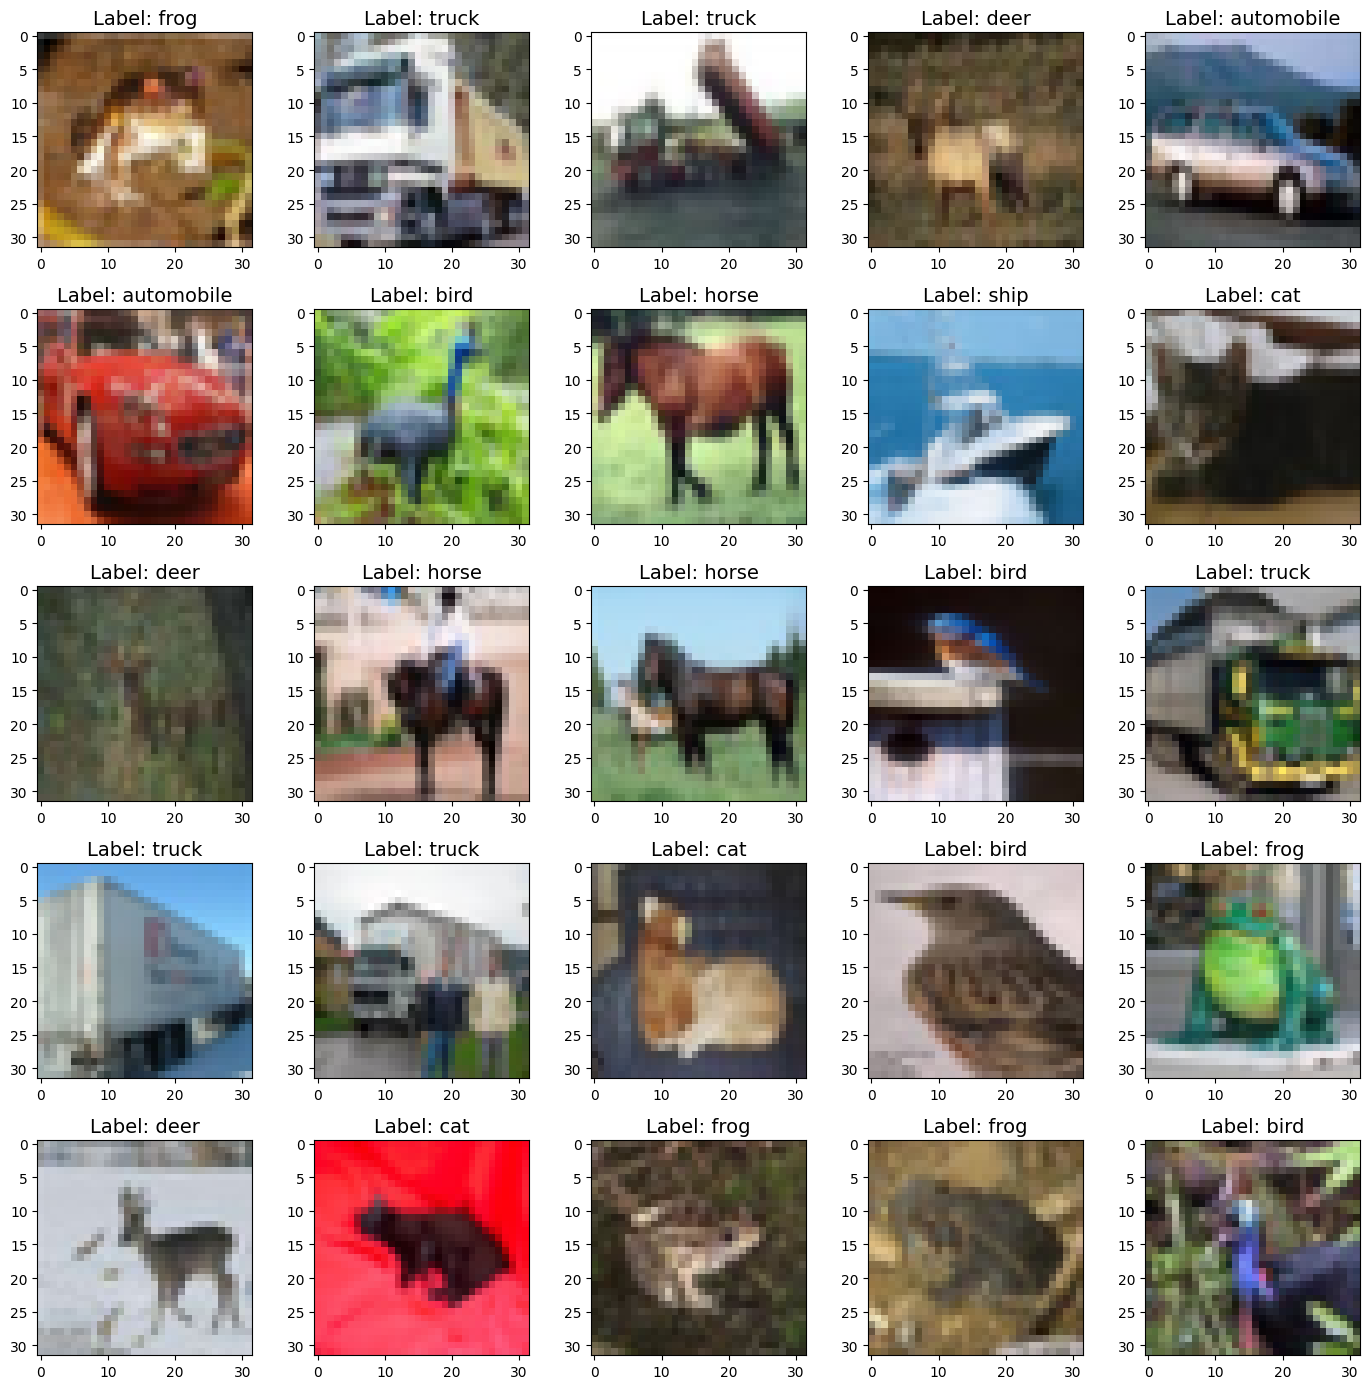

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(14, 14))
for i in range(25):
    image, label = train_data[i]
    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"Label: {classes[label]}", fontdict={"fontsize": 14})
plt.tight_layout()
plt.show()

## Augmentation

On the training dataset, we will use some data augmentation: RandomHorizontalFlip, RandomCrop and Normalize. Flipping the image horizontally should still allow the network to guess the correct class, as e.g. a frog mirrored left-to-right is still a frog. RandomCrop will in this case yield 32x32 crops of the input image, and add padding on the sides (see visualization below). This augmentation preserves the main part of the image, but moves the image content around and adds some padding on the sides. This should still allow the network to guess the correct class, as we do not crop out too much of the image. One could also use other augmentation methods such as RandomRotation, but these are the augmentation methods described in the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).

This augmentation can artificially enlarge the number of training examples we have in our dataset and help to prevent overfitting.

In [7]:
from torchvision.transforms import ToTensor, Compose, Normalize, RandomHorizontalFlip, RandomCrop
from torch.utils.data import DataLoader

# Image transforms
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
normalize = Normalize(mean=normalize_mean, std=normalize_std)

train_transform = Compose([
    RandomHorizontalFlip(),
    RandomCrop(32, 4),
    ToTensor(),
    normalize
])
val_transform = Compose([
    ToTensor(),
    normalize
])

train_data_torch = CIFAR10('./cifar', download=True, train=True, transform=train_transform)
val_data_torch = CIFAR10('./cifar', download=True, train=False, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


Instead of writing our own `Loader` class, as we did in the previous exercises, we will now use the pytorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class for this. It takes a dataset that must be either iterable or indexable and have a length (`__len__`). The Dataloader can be iterated with `for batch in dataloader: ...`, as we did in the previous exercises. The DataLoader class has some improvements to our own `Loader` class, e.g. it can perform the image augmentation on dedicated worker processes, speeding up the training heavily if the augmentation is slow.

In [8]:
BATCH_SIZE = 128
train_loader = DataLoader(train_data_torch, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data_torch, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

## Network

In this notebook, we will not use the ResNet18 model provided by torchvision. The ResNet18 model is adapted for larger images, such as the 224x224 images used in the ImageNet dataset. In the original [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf), they used a slightly different architecture (ResNet20) to train and evaluate on the CIFAR-10 dataset with its 32x32 images. The changes include:
 - Replacing the 64 7x7 filters at the start of the network with 16 3x3 filters
 - Using 3 residual layers instead of 4, and reducing the number of filters learned in the layers (from [64, 128, 256, 512] to [16, 32, 64])
 - Using 3 residual blocks per layer instead of 2

Below you will find an almost complete ResNet architecture implementation. Your task is to fill in the implementation of the `ResidualBlock` class. To recap, the ResidualBlock performs 2x `Conv + BatchNorm + ReLU`, where the first convolution may have stride 1 or 2, and the other has stride 1. The result of this is added to the input of the block (i.e., the block calculates the residual). If the block has to perform a stride or the number of channels at the beginning of the block (`channels_in`) is not equal to the number of channels the block should have (`K`), the skip connection has to perform a 1x1 convolution followed by a BatchNorm, so that the numbers of filters and the stride are matching when the addition is performed.

To sum up, there are two variants that the ResidualBlock can behave in:

1. Without 1x1 convolution in the skip connection (if `channels_in == K` and `stride == 1`):

<img src="residual_block_identity.svg" width="300" height="400" />

2. With 1x1 convolution in the skip connection:

<img src="residual_block.svg" width="300" height="400" />

In [9]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels_in, K, stride=1):
        super(ResidualBlock, self).__init__()

        # stride is the stride to be performed in the first convolution. The other convolution always has stride 1.
        # channels_in is the number of channels in the input tensor
        # K is the number of filters that each convolution should learn in this block

        self.conv1 = nn.Conv2d(channels_in, K, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(K)


        self.conv2 = nn.Conv2d(K, K, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(K)

        if channels_in != K or stride > 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(channels_in, K, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(K)
            )
        else:
            self.shortcut = nn.Identity()
        pass

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        # econd convolution
        out = self.bn2(self.conv2(out))

        # skip connection
        shortcut = self.shortcut(x)
        out += shortcut
        out = F.relu(out)

        return out
        pass


class ResidualLayer(nn.Module):
    def __init__(self, K_in, K, num_blocks, stride=1, block=ResidualBlock):
        super(ResidualLayer, self).__init__()

        modules = [block(K_in, K, stride=stride)]

        for j in range(num_blocks-1):
            modules.append(block(K, K))

        self.model = nn.Sequential(*modules)

    def forward(self, x):
        x = self.model(x)
        return x


class CIFAR10ResNet20(nn.Module):
    def __init__(self, num_classes, block=ResidualBlock):
        super(CIFAR10ResNet20, self).__init__()
        # number of blocks per layer
        self.layers = [3, 3, 3]
        # filter sizes / channels per layer
        self.filters = [16, 32, 64]
        # stride of the first block in each layer
        self.strides = [1, 2, 2]

        # The number of filters for the first conv layer
        C0 = 16
        modules = []
        conv1 = nn.Conv2d(3, C0, (3, 3), padding=1, stride=1, bias=False)

        modules += [
            conv1,
            nn.BatchNorm2d(C0),
            nn.ReLU()
        ]

        # instantiate all the layers
        for i in range(len(self.layers)):
            in_channels = C0 if i == 0 else self.filters[i-1]
            modules.append(ResidualLayer(
                in_channels, self.filters[i], self.layers[i], stride=self.strides[i], block=block))

        # adaptive max pooling reduces the remaining image to a 1x1 image with the previous
        # number of channels (self.filters[-1])
        modules.append(nn.AdaptiveAvgPool2d((1, 1)))

        # our model is a simple sequential flow of the previously defined modules
        # (skip connections were already handled in the ResidualBlocks)
        self.model = nn.Sequential(*modules)
        # Classification layer
        self.linear = nn.Linear(self.filters[-1], num_classes)
        # note that there is no softmax layer here because cross_entropy loss in pytorch
        # already includes the softmax operation.

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.model(x)

        # flatten the tensor to a 1D array (but with batch_size still intact)
        x = x.view(x.size(0), -1)

        x = self.linear(x)
        return x

#### Training

Ok, now on to the actual training. We instantiate the network and the optimizer:

In [10]:
model = CIFAR10ResNet20(num_classes=10)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
LR = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=0.0001, momentum=0.9)

In [11]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

The training loop is very similar to the last exercises. One difference is the addition of a `train_batch_epoch_limit` variable. This allows us to decrease the number of batches that we process per training epoch. If one does not have a GPU, iterating the whole 60000 images of the training set takes quite some time. If we decrease the number of batches per epoch, we can perform shorter epochs and thus log the training accuracy more frequently.

In [13]:
from torch.nn.functional import cross_entropy
import numpy as np
import tqdm

NUM_EPOCHS = 20
NUM_CLASSES = 10

train_batch_epoch_limit = 100
val_batch_epoch_limit = 100

for epoch in range(NUM_EPOCHS):
    # perform training followed by validation
    for mode, loader, batch_epoch_limit in [
        ("train", train_loader, train_batch_epoch_limit),
        ("val", val_loader, val_batch_epoch_limit)
    ]:
        # progressbar setup
        num_batches = min(len(loader), batch_epoch_limit)
        pbar = tqdm.tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train() # do calculate gradients for training mode
        else:
            model.eval() # do not calculate gradients in validation mode

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0
        # total number of images that were processed
        total_samples = 0

        # loop over the data
        for i_batch, batch in zip(range(num_batches), loader):
            images, labels = batch
            # move tensors to the correct device
            images = images.to(device)
            labels = labels.to(device)

            # run the model
            predictions = model.forward(images)

            # loss calculation
            loss = cross_entropy(predictions, labels)

            # calculate the metrics for the progress bar
            num_batch_samples = len(images)
            runningLoss += loss.item() * num_batch_samples
            correct_predictions += (torch.argmax(predictions, dim=-1) == labels).sum().item()
            total_samples += num_batch_samples

            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples,
                "accuracy": correct_predictions / total_samples
            })

            # weight update
            if mode == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epoch_loss = runningLoss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_accuracy)

        pbar.close()

val epoch 19: 100%|██████████| 79/79 [00:11<00:00,  6.94it/s, loss=0.758, accuracy=0.752]


You can leave this running for a few epochs, to see that it is learning something, and stop the training whenever you want. After that, you can plot the training progress with the following code:

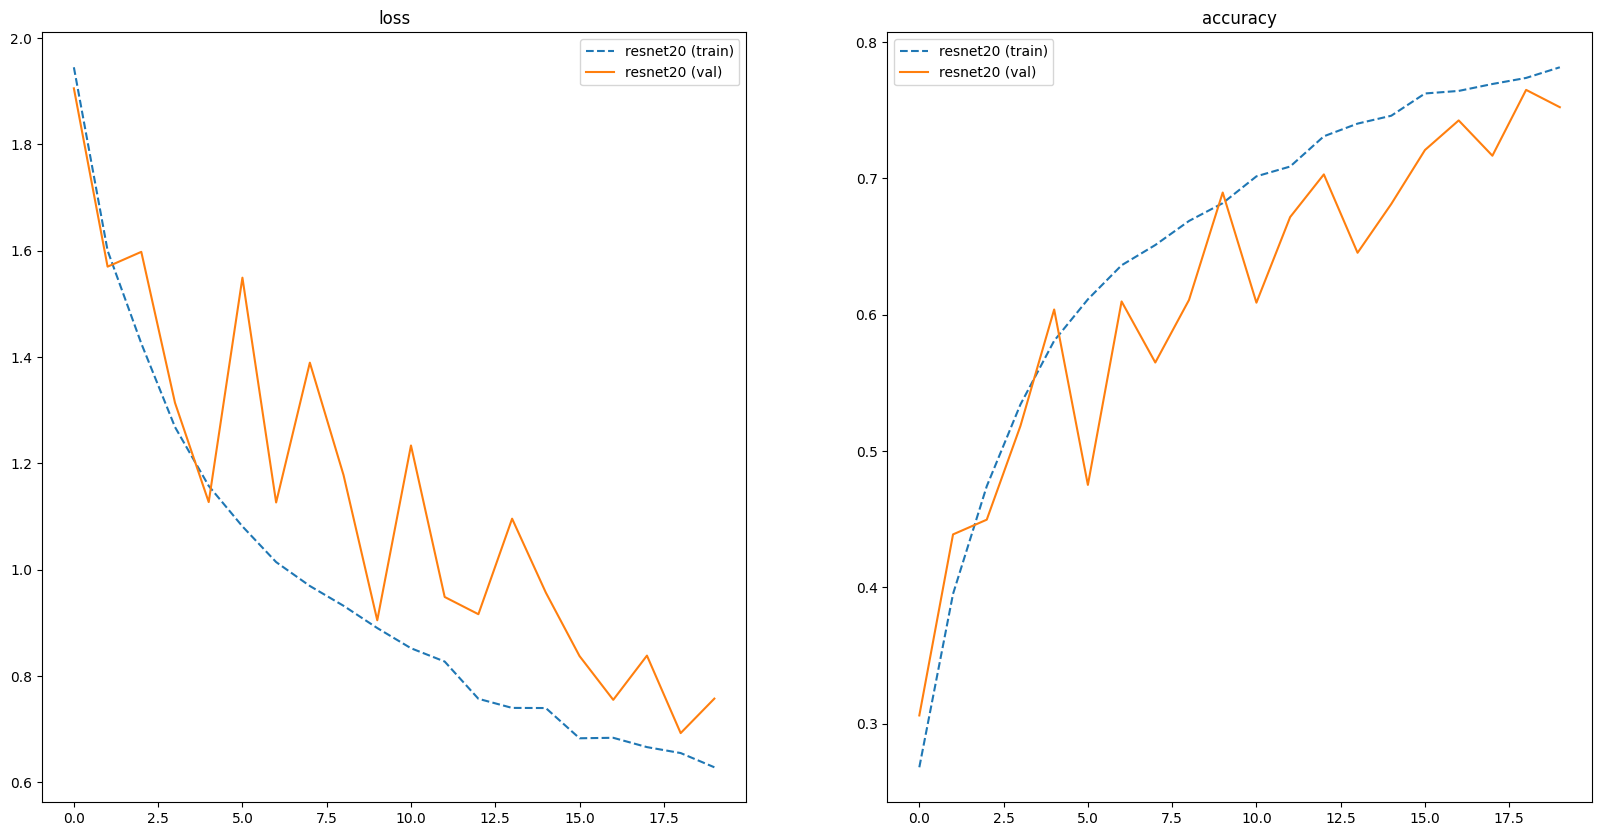

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
label = 'resnet20'
axes[0].set_title('loss')
axes[0].plot(train_losses, '--', label=f"{label} (train)")
axes[0].plot(val_losses, label=f"{label} (val)")
axes[0].legend()
axes[1].set_title('accuracy')
axes[1].plot(train_accuracy, '--', label=f"{label} (train)")
axes[1].plot(val_accuracy, label=f"{label} (val)")
axes[1].legend()

plt.show()

If you were leaving this running for a large number of epochs (e.g. 200) on the full dataset (e.g. set train_batch_epoch_limit to a large value), you could expect the ResNet to get about 91.25% accuracy, according to the original paper. For this, one should also decrease the learning rate after 32k and 48k iterations, as described in the paper. In general, even if you stop training earlier you should notice an improvement in performance against the number of iterations i.e. decrease in train/val loss and increase of train/val accuracy.

## Visualizing results

We can also visualize the predictions of the network on the validation set. Note that now we have to use the softmax operation on the model's results, if we want to obtain classification probabilities.

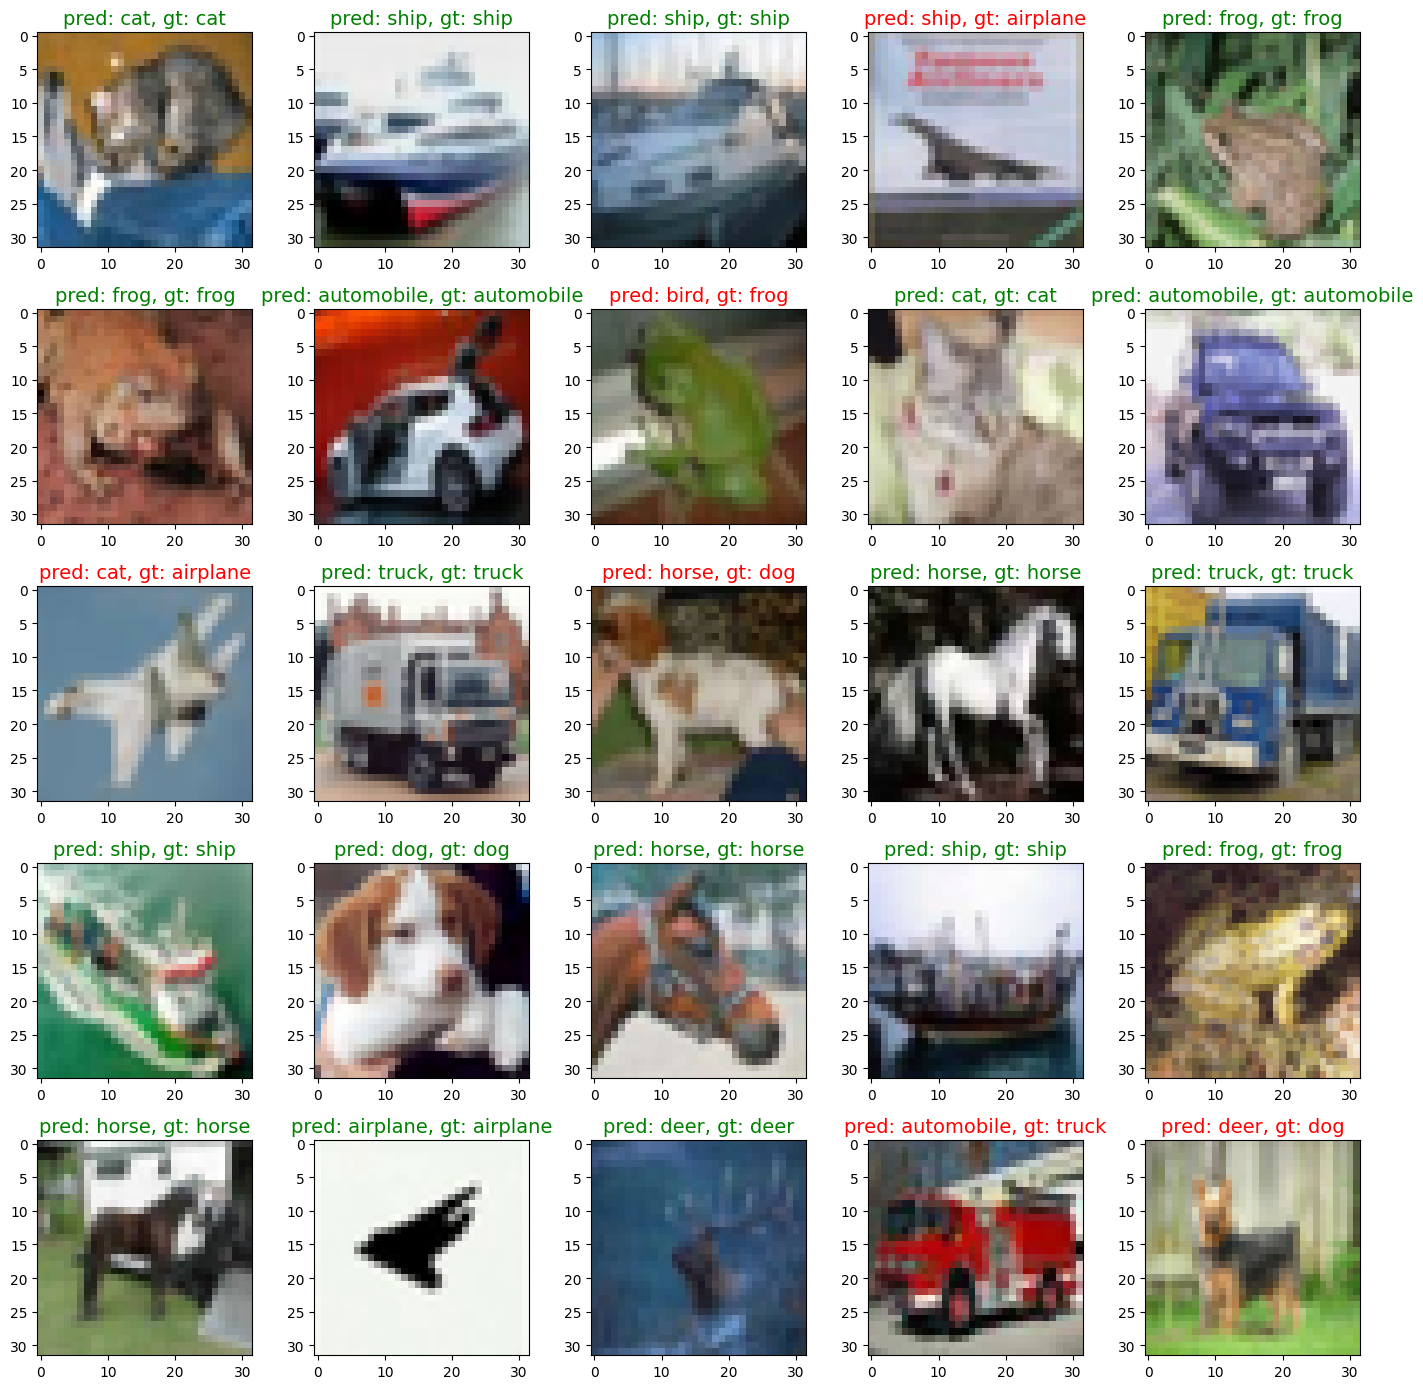

In [15]:
from torchvision.transforms.functional import to_pil_image
from math import ceil

num_test_samples = 25
images, labels = next(val_loader.__iter__())

num_cols = 5
num_rows = int(ceil(num_test_samples/num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

model.eval()
predictions = model(images.to(device))
scores = nn.functional.softmax(predictions, dim=-1)
predicted_classes = torch.argmax(scores, dim=-1)
# actually if we only need the index of the class with the highest probability, we could omit the softmax operation and perform argmax on the logits directly.
# predicted_classes = torch.argmax(predictions, dim=-1)

for i in range(num_test_samples):
    image, label = images[i], labels[i]
    predicted_class = predicted_classes[i].cpu().item()

    # undo image normalization
    for channel in range(3):
        image[channel] *= normalize_std[channel]
        image[channel] += normalize_mean[channel]
    # transform tensor back to a PIL image
    image = to_pil_image(image)

    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(image)
    ax.set_title(f"pred: {classes[predicted_class]}, gt: {classes[label]}", fontdict={"fontsize": 14, "color": ("green" if predicted_class == label else "red")})
plt.tight_layout()
plt.show()

# Bonus tasks

 - The `ResidualBlock` module performs two 3x3 convolutions. In the ResNet paper, an alternative block, the bottleneck block is discussed. In this, the two 3x3 convolutions are replaced with a sequence of one 1x1 convolution, one 3x3 convolution and then a final 1x3 convolution. Here, the first 1x1 convolution reduces the number of channels of the input tensor so that the 3x3 convolution is computationally less expensive. The final 1x1 convolution then restores the previous dimension. Implement this in a `BottleneckBlock` class. You can pass the block module that should be used to the `CIFAR10ResNet20` via the `block` argument.
 - In the residual blocks, one can also use "pre-activations" (see [this paper](https://arxiv.org/pdf/1603.05027.pdf)). This means, that BatchNorm and ReLU are performed before the convolutions instead of after them. This further increases the network performance. Adjust the block implementation accordingly.
 - In this notebook, we only calculate the accuracy, which means that the class for which the network calculated the highest probability has to match the label. A common metric on datasets with a higher number of classes is Top-K-Accuracy. For this, the correct class has to occur in the K classes that the network predicted the highest probabilities for. Implement a Top-3-Accuracy metric and draw the graph for it.